# Entendimento do Problema

Objetivo do Problema:
- 1.0. Previsao do primeiro destino que um novo usuário irá escolher.
    - Porque?
    - Qual tipo de modelo de negócio do Airbnb?
        - Marketplace (Conectar pessoas que oferecem acomodacao, com pessoas que estao procurando acomodacao)
        - Oferta (pessoas oferecendo acomodacao)
            - Tamanho do portfólio.
            - Diversidade/Densidade de Portfólio.
            - Preco Medio
            
        - Demanda (pessoas procurando acomodacao)
            - Numero de Usuários
            - LTV (Lifetime Value)
            - CAC (Client Acquisition Cost)
            
            
           Gross Revenue = (Fee*Numero cliente) - CAC 

- Proposta da Solucao
- Modelo de Predivao do primeiro destino de um novo usario.
- 1.0. Predicoes e salva em tabela do banco de dados. 
- 2.0. API 
    - Input: usuario e suas caracteristicas
    - Output: usuario e suas caracteristicas com a **predicao do destino**

# 0.0 Imports

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
from sklearn import model_selection as ms
from sklearn import preprocessing as pp
from sklearn import metrics as m
from scikitplot import metrics as mt
from scipy import stats as ss

from keras import models as ml
from keras import layers as l

##  0.1. Helper Functions

In [4]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

##  0.2. Carregando dados

In [5]:
df_raw = pd.read_csv('../dados/train_users_2.csv', low_memory=True)
df_raw.shape

(213451, 16)

In [6]:
df_sessions = pd.read_csv('../dados/sessions.csv', low_memory=True)
df_sessions.shape

(10567737, 6)

# 1.0. Descrição dos Dados

In [7]:
df1 = df_raw.copy()

## 1.1. Dimensão dos Dados

In [8]:
print('Usuários Número de Linhas: {}'.format(df1.shape[0]))
print('Usuários Número de Colunas: {}'.format(df1.shape[1]))

Usuários Número de Linhas: 213451
Usuários Número de Colunas: 16


In [9]:
print('Usuários Número de Linhas: {}'.format(df_sessions.shape[0]))
print('Usuários Número de Colunas: {}'.format(df_sessions.shape[1]))

Usuários Número de Linhas: 10567737
Usuários Número de Colunas: 6


##  1.2. Tipo Dados

In [10]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [11]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.3. Check NA

In [12]:
df1.isna().sum() / len(df1) * 100

id                          0.000000
date_account_created        0.000000
timestamp_first_active      0.000000
date_first_booking         58.347349
gender                      0.000000
age                        41.222576
signup_method               0.000000
signup_flow                 0.000000
language                    0.000000
affiliate_channel           0.000000
affiliate_provider          0.000000
first_affiliate_tracked     2.841402
signup_app                  0.000000
first_device_type           0.000000
first_browser               0.000000
country_destination         0.000000
dtype: float64

In [13]:
df_sessions.isna().sum() / len(df_sessions) * 100

user_id           0.326428
action            0.753482
action_type      10.657003
action_detail    10.657003
device_type       0.000000
secs_elapsed      1.287229
dtype: float64

In [14]:
# Dataset Usuário

# date_first_booking_max
date_first_booking_max = pd.to_datetime(df1['date_first_booking']).max().strftime('%Y-%m-%d')
df1['date_first_booking'] = df1['date_first_booking'].fillna(date_first_booking_max)

# age
df1 = df1[(df1['age'] > 15) & (df1['age'] < 120)]
avg_age = df1['age'].mean().astype(int)
df1['age'] = df1['age'].fillna(avg_age)

# first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]

In [15]:
# Dataset Sessions
# user_id - 0.3%
df_sessions = df_sessions[~df_sessions['user_id'].isna()]

# action - 0.7%
df_sessions = df_sessions[~df_sessions['action'].isna()]

# action_type - 11%
df_sessions = df_sessions[~df_sessions['action_type'].isna()]

# action_detail - 11%
df_sessions = df_sessions[~df_sessions['action_detail'].isna()]

# secs_elapsed - 1.2%
df_sessions = df_sessions[~df_sessions['secs_elapsed'].isna()]

In [16]:
df1.isna().sum() / len(df1) * 100

id                         0.0
date_account_created       0.0
timestamp_first_active     0.0
date_first_booking         0.0
gender                     0.0
age                        0.0
signup_method              0.0
signup_flow                0.0
language                   0.0
affiliate_channel          0.0
affiliate_provider         0.0
first_affiliate_tracked    0.0
signup_app                 0.0
first_device_type          0.0
first_browser              0.0
country_destination        0.0
dtype: float64

In [17]:
df_sessions.isna().sum() / len(df_sessions) * 100

user_id          0.0
action           0.0
action_type      0.0
action_detail    0.0
device_type      0.0
secs_elapsed     0.0
dtype: float64

## 1.4. Mudando dTyepes

In [18]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [19]:
 # date_account_created
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'])

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S')

# date_first_booking
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])

# age
df1['age'] = df1['age'].astype(int)

## 1.5. Valida Balanceamento

In [20]:
df1['country_destination'].value_counts(normalize=True) * 100

NDF      44.727486
US       39.186699
other     6.124629
FR        2.991781
IT        1.642258
GB        1.433511
ES        1.373985
CA        0.867608
DE        0.685769
NL        0.485176
AU        0.353077
PT        0.128021
Name: country_destination, dtype: float64

## 1.6. Análise descritiva

In [21]:
# Users
num_attributes = df1.select_dtypes(include=['int64', 'float64', 'int32'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]', 'int32'])
time_attributes = df1.select_dtypes(include=['datetime64[ns]'])

# Sessions
num_attributes_sessions = df_sessions.select_dtypes(include=['int64', 'float64', 'int32'])
cat_attributes_sessions = df_sessions.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]', 'int32'])
time_attributes_sessions = df_sessions.select_dtypes(include=['datetime64[ns]'])

In [22]:
def get_analise_descritiva(df):
    d0 = df.describe()
    d1 = pd.DataFrame(df.apply(lambda x: x.skew())).T
    d2 = pd.DataFrame(df.apply(lambda x: x.kurtosis())).T
    d3 = pd.DataFrame(df.apply(lambda x: x.max() - x.min())).T
    ct = pd.concat([d0, d3, d1, d2]).T.reset_index()
    ct.columns = ['Atributos', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'range', 'skew', 'kurtosis']
    return ct

### 1.6.1. Númerico - Users

In [23]:
get_analise_descritiva(num_attributes)

,Atributos,count,mean,std,min,25%,50%,75%,max,range,skew,kurtosis
0,age,122636.0,37.405591,13.939900,16.0,28.0,34.0,43.0,115.0,99.0,2.089718,6.516468
1,signup_flow,122636.0,2.519513,6.604723,0.0,0.0,0.0,0.0,25.0,25.0,2.705871,5.928298


### 1.6.2. Númerico - Sessions

In [24]:
get_analise_descritiva(num_attributes_sessions)

,Atributos,count,mean,std,min,25%,50%,75%,max,range,skew,kurtosis
0,secs_elapsed,9213930.0,19961.8251,88849.39327,0.0,333.0,1369.0,9796.0,1799977.0,1799977.0,11.137761,154.84312


### 1.6.3. Categórico - Users

In [25]:
cat_attributes.drop('id', axis=1).describe() 

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,122636,122636,122636,122636,122636,122636,122636,122636,122636,122636
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,56362,66039,118205,79093,78954,64712,108283,57943,41778,54852


### 1.6.4. Categórico - Sessions

In [26]:
cat_attributes_sessions.drop('user_id', axis=1).describe() 

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


In [27]:
cat_attributes_list = cat_attributes_sessions.drop('user_id', axis=1).columns.tolist()

corr_dict = {}
for i in range(len (cat_attributes_list)):
    corr_list = []
    for j in range(len(cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes_sessions[ ref ], cat_attributes_sessions[ feat ])
        
        # append a list
        corr_list.append(corr)
    
    # appende a correlation list for each ref attributs
    corr_dict[ ref ] = corr_list

<AxesSubplot: >

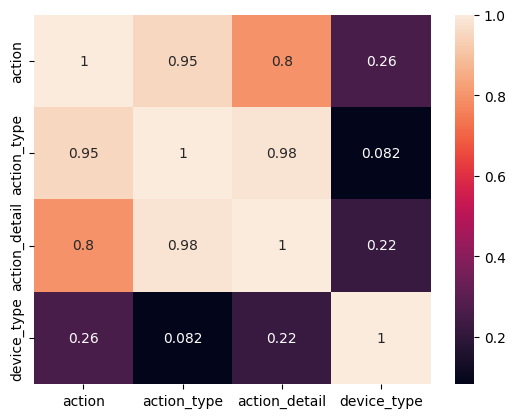

In [28]:
tmp = pd.DataFrame(corr_dict)
tmp = tmp.set_index(tmp.columns)
sns.heatmap(tmp, annot=True)

# 2.0. Filtragem Dados

In [29]:
df2 = df1.copy()

## 2.1. Filtragem Linhas

In [30]:
# Filtrando Idade maior que 15 e menor que 120 anos.
df2 = df2[(df2['age'] > 15) & (df2['age'] < 120)]

## 2.2. Seleção Colunas

# 3.0. Preparação Dados

In [31]:
df3 = df2.copy()
df3.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,2015-06-29,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
6,lsw9q7uk0j,2010-01-02,2010-01-02 01:25:58,2010-01-05,FEMALE,46,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US


In [32]:
df3_dummy = pd.get_dummies(df3.drop(['id', 'country_destination'], axis=1))
df3_dummy.head()

,date_account_created,timestamp_first_active,date_first_booking,age,signup_flow,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,...,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
1,2011-05-25,2009-05-23 17:48:09,2015-06-29,38,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2010-09-28,2009-06-09 23:12:47,2010-08-02,56,3,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,2011-12-05,2009-10-31 06:01:29,2012-09-08,42,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2010-09-14,2009-12-08 06:11:05,2010-02-18,41,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,2010-01-02,2010-01-02 01:25:58,2010-01-05,46,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [33]:
df3 = pd.concat([df3[['id', 'country_destination']], df3_dummy], axis=1) 
df3.head()

,id,country_destination,date_account_created,timestamp_first_active,date_first_booking,age,signup_flow,gender_-unknown-,gender_FEMALE,gender_MALE,...,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
1,820tgsjxq7,NDF,2011-05-25,2009-05-23 17:48:09,2015-06-29,38,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,4ft3gnwmtx,US,2010-09-28,2009-06-09 23:12:47,2010-08-02,56,3,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,bjjt8pjhuk,other,2011-12-05,2009-10-31 06:01:29,2012-09-08,42,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,87mebub9p4,US,2010-09-14,2009-12-08 06:11:05,2010-02-18,41,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,lsw9q7uk0j,US,2010-01-02,2010-01-02 01:25:58,2010-01-05,46,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


# 4.0. Seleção Features

In [34]:
# Remove datas originais pois é inútil para o modelo.
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking']

df4 = df3.drop(cols_drop, axis=1)

X = df4.drop('country_destination', axis=1)
y = df4['country_destination'].copy()

X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42)

# 5.0. Machine Learning

In [35]:
x_train = X_train.drop('id', axis=1)
x_test = X_test.drop('id', axis=1)

## 5.1. Baseline 

In [36]:
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
country_destination_weights = df1['country_destination'].value_counts(normalize=True).sort_index().tolist()

yhat_random = random.choices(population=country_destination_list,  
                             weights=country_destination_weights,
                             k=k_num)
len(yhat_random)

24528

### 5.1.1 Baseline Performance

Accuracy: 0.35832517938682323
Balanced Accuracy:0.08049709645443359
Kappa Score: -0.0030181022766953003
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        92
          CA       0.01      0.01      0.01       208
          DE       0.00      0.00      0.00       160
          ES       0.02      0.02      0.02       286
          FR       0.03      0.03      0.03       767
          GB       0.00      0.00      0.00       334
          IT       0.01      0.01      0.01       440
         NDF       0.45      0.44      0.45     11016
          NL       0.00      0.00      0.00       111
          PT       0.00      0.00      0.00        29
          US       0.39      0.39      0.39      9619
       other       0.05      0.06      0.06      1466

    accuracy                           0.36     24528
   macro avg       0.08      0.08      0.08     24528
weighted avg       0.36      0.36      0.36     24528



<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

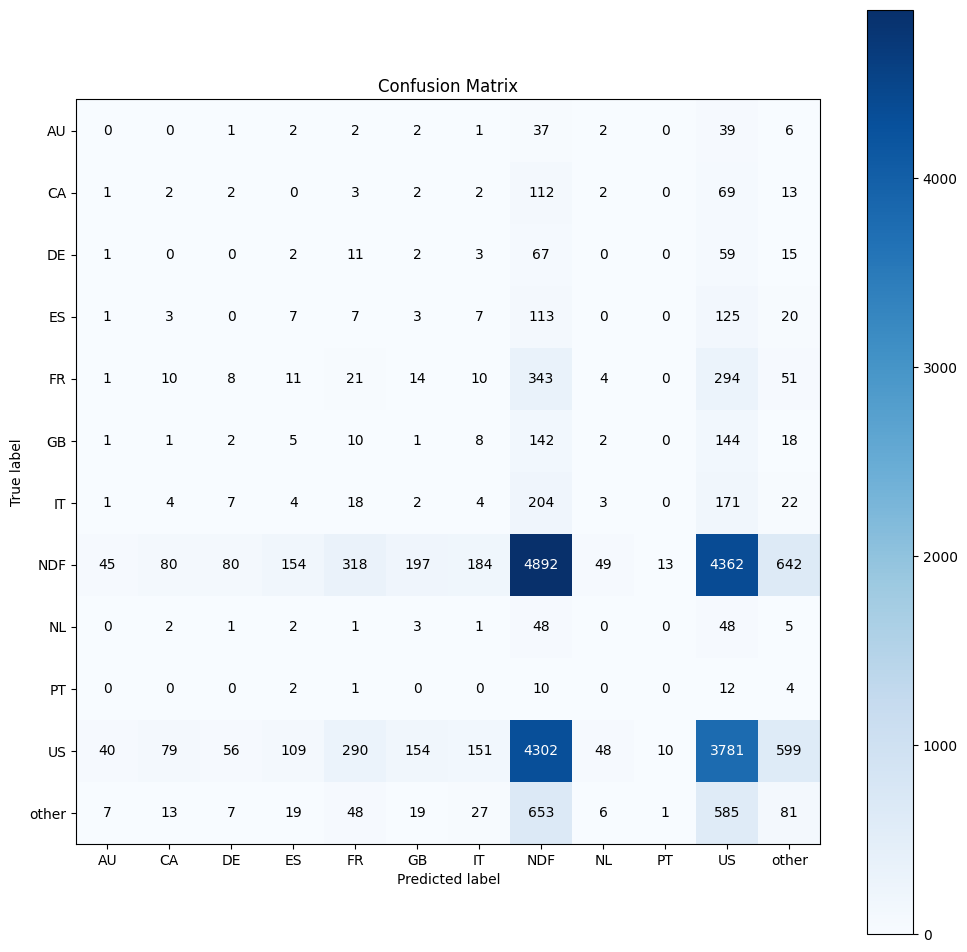

In [37]:
# Accuracy
acc_random = m.accuracy_score(y_test, yhat_random)
print('Accuracy: {}'.format(acc_random))

# Balanced Accuray
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print('Balanced Accuracy:{}'.format(balanced_acc_random))

# Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print('Kappa Score: {}'.format(kappa_random))

# Classification report
print(m.classification_report(y_test, yhat_random))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(12,12))

## 5.2. Neural Network MLP

In [38]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()

# Definição Modelo
model = ml.Sequential()
model.add(l.Dense(256, input_dim=x_train.shape[1], activation='relu'))
model.add(l.Dense(12, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Treino
model.fit(x_train, y_train_nn, epochs=100, verbose=True)

Epoch 1/100
3066/3066 [==============================] - 3s 986us/step - loss: 1.3091 - accuracy: 0.5200
Epoch 2/100
3066/3066 [==============================] - 3s 903us/step - loss: 1.2827 - accuracy: 0.5283
Epoch 3/100
3066/3066 [==============================] - 3s 1ms/step - loss: 1.2736 - accuracy: 0.5302
Epoch 4/100
3066/3066 [==============================] - 3s 880us/step - loss: 1.2703 - accuracy: 0.5312
Epoch 5/100
3066/3066 [==============================] - 3s 865us/step - loss: 1.2683 - accuracy: 0.5322
Epoch 6/100
3066/3066 [==============================] - 3s 879us/step - loss: 1.2663 - accuracy: 0.5337
Epoch 7/100
3066/3066 [==============================] - 3s 878us/step - loss: 1.2646 - accuracy: 0.5341
Epoch 8/100
3066/3066 [==============================] - 3s 881us/step - loss: 1.2634 - accuracy: 0.5339
Epoch 9/100
3066/3066 [==============================] - 3s 902us/step - loss: 1.2627 - accuracy: 0.5348
Epoch 10/100
3066/3066 [==============================] -

### 5.2.1 NN Performance

In [39]:
# Predição
pred_nn = model.predict(x_test)

# Inverte predição
yhat_nn = ohe.inverse_transform(pred_nn)

y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

767/767 [==============================] - 1s 612us/step


Acurácia: 0.533675799086758
Balanced Accuracy:0.10626010660460865
Kappa Score: 0.1983561881225845


g:\projetos\cds\previsao_agendamento_acomodacao\.venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
g:\projetos\cds\previsao_agendamento_acomodacao\.venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        92
          CA       0.00      0.00      0.00       208
          DE       0.00      0.00      0.00       160
          ES       0.00      0.00      0.00       286
          FR       0.14      0.00      0.01       767
          GB       0.00      0.00      0.00       334
          IT       0.00      0.00      0.00       440
         NDF       0.59      0.62      0.61     11016
          NL       0.00      0.00      0.00       111
          PT       0.00      0.00      0.00        29
          US       0.48      0.65      0.55      9619
       other       0.25      0.00      0.00      1466

    accuracy                           0.53     24528
   macro avg       0.12      0.11      0.10     24528
weighted avg       0.47      0.53      0.49     24528



g:\projetos\cds\previsao_agendamento_acomodacao\.venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

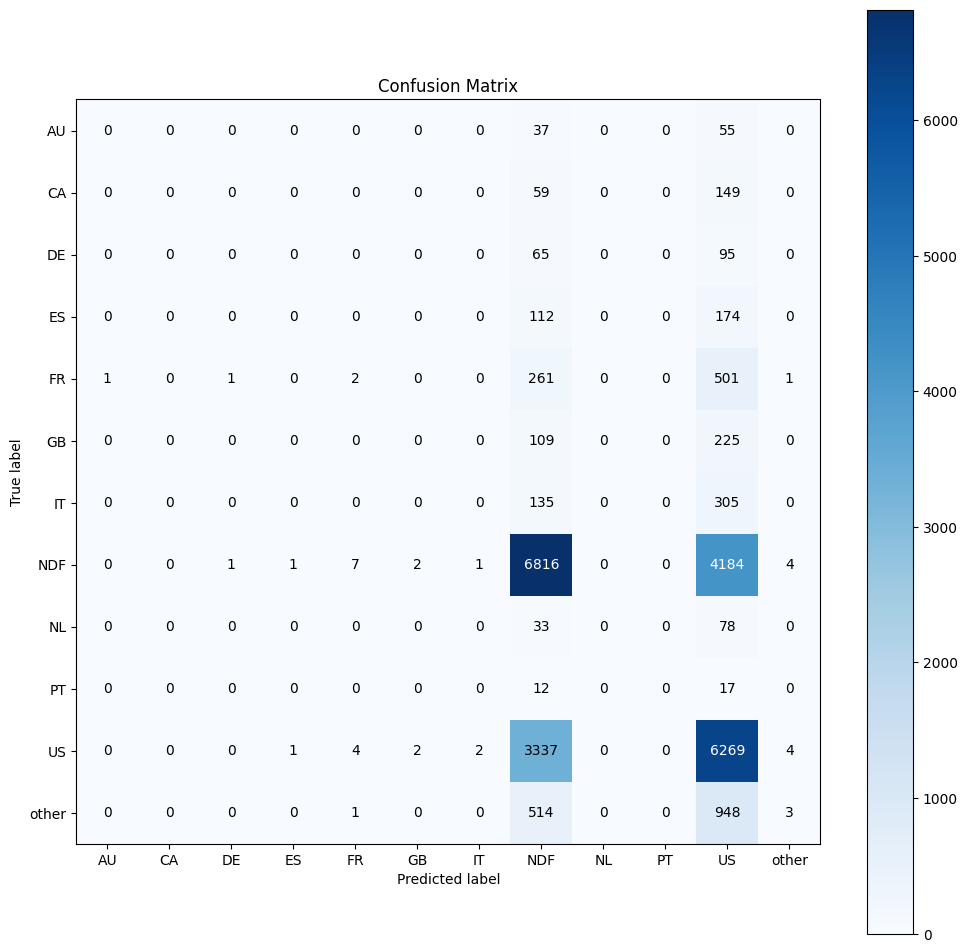

In [40]:
# Acurácia
acc_nn =m.accuracy_score(y_test_nn, yhat_nn)
print(f'Acurácia: {acc_nn}')

# Balanced Accuray
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print('Balanced Accuracy:{}'.format(balanced_acc_nn))

# Kappa
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print('Kappa Score: {}'.format(kappa_nn))

# Classification report
print(m.classification_report(y_test_nn, yhat_nn))

# Matriz de Confusão
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(12,12))

Acurácia: 0.7094976164283096

Balanced Accuracy:0.09153183873284591

Kappa Score: 0.004007337133695277

### 5.2.1 NN Performance - Cross-Validation

In [41]:
num_folds = 5
kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split(x_train, y_train):
    print(f'Fold {i}/{num_folds}')

    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]

    # target hot-encoding
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape(-1, 1)).toarray()

    # Definição Modelo
    model = ml.Sequential()
    model.add(l.Dense(256, input_dim=x_train.shape[1], activation='relu'))
    model.add(l.Dense(12, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Treino modelo
    model.fit(x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0)

    # Predição
    pred_nn = model.predict(x_val_fold)
    yhat_nn = ohe.inverse_transform(pred_nn)
    
    # Ajusta os dados com reshape
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape(1, -1)[0]

    # Métricas
    ## Balanced Accuracy 
    balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
    balanced_acc_list.append(balanced_acc_nn)
    
    ## Kappa Metrics
    kappa_acc_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
    kappa_acc_list.append(kappa_acc_nn)
    
    i += 1   


Fold 1/5
614/614 [==============================] - 0s 657us/step
Fold 2/5
614/614 [==============================] - 0s 672us/step
Fold 3/5
614/614 [==============================] - 0s 671us/step
Fold 4/5
614/614 [==============================] - 0s 674us/step
Fold 5/5
614/614 [==============================] - 0s 679us/step


In [42]:
print('Avg Balanced Accuracy: {} +/- {}'.format(np.round(np.mean(balanced_acc_list), 2), 
                                                  np.round(np.std(balanced_acc_list), 4)))
print('Avg Kappa: {} +/- {}'.format(np.round(np.mean(kappa_acc_list), 4), 
                                      np.round(np.std(kappa_acc_list), 4)))

Avg Balanced Accuracy: 0.11 +/- 0.0008
Avg Kappa: 0.1859 +/- 0.0068


Avg Balanced Accuracy: 0.09 +/- 0.0003

Avg Kappa: 0.003 +/- 0.0018